# Assignemnt 1 for the CGT/LD course

In [1]:
import numpy as np
# Plotting libraries
import matplotlib.pylab as plt
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline
# This enables high resolution PNGs.
%config InlineBackend.figure_formats = {'png', 'svg'}

## Execise 1.3 : Find the set of Nash equilibria (pure and mixed) in the Hawk-Dove game

### Example

In [2]:
import nashpy as nash

In [3]:
def hawk_dove_game_equilibria(V, D, T):
    """
    This function returns the Nash equilibria of
    a Hawk-Dove game with its payoff matrix being a
    function of V, D and T.
    """
    # payoff matrix for the row player
    hg_matrix_row = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])
    # payoff matrix for the column player
    hg_matrix_col = hg_matrix_row.T
    
    # Create game
    game = nash.Game(hg_matrix_row, hg_matrix_col)
    
    # Find all equilibria
    return list(game.support_enumeration())

#### Find Nash equilibria

Comment this section if you do not have ipywidgets installed!

In [4]:
from ipywidgets import interact, FloatSlider

In [5]:
@interact(V=FloatSlider(min=-10, max=10, step=0.1, value=2), 
          D=FloatSlider(min=-10, max=10, step=0.1, value=3), 
          T=FloatSlider(min=-10, max=10, step=0.1, value=1))
def show_articles_more_than(V=2, D=3, T=1):
    return hawk_dove_game_equilibria(V, D, T)

interactive(children=(FloatSlider(value=2.0, description='V', max=10.0, min=-10.0), FloatSlider(value=3.0, des…

## Execise 3.1 : Evolutionary Dynamics of the Hawk-Dove Game in Infinite populations

### Replicator equation

The replicator equation represents the dynamics of competing individuals in a population. It normally found in the following form:

$\dot{x}_i = x_i[f(x_i)-\sum_{i=1}^{n}x_if(x_i)]$,

where $x_i$ represents the frequency of strategy $i$ in the population, and $f(x_i)$ is the fitness of strategy $i$. This differencial equation, gives the gradient of selection, i.e., the strength with which the frequency of a certain strategy will increase or decrease. It may also be expressed in a more convenient matrix form:

$G(x_i) = \dot{x}_i = x_i[(Ax)_i - x^TAx]$

Where the matrix $A$ is a payoff matrix with element $A_{ij}$ representing the fitness of strategy $i$ over strategy $j$.

1. Below you may find the dynamics of the Hawk-Dove Game infinite populations. Use the code provided to answer the questions in your assignment.

In [6]:
from egttools.analytical import replicator_equation
from egttools.utils import find_saddle_type_and_gradient_direction
from egttools.plotting import plot_gradient

In [7]:
nb_points = 101
strategy_i = np.linspace(0, 1, num=nb_points, dtype=np.float64)
strategy_j = 1 - strategy_i
states = np.array((strategy_i,strategy_j)).T

# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [8]:
# Calculate gradient
G = np.array([replicator_equation(states[i], A)[0] for i in range(len(states))])

In [9]:
# Find saddle points (where the gradient is 0)
epsilon = 1e-7
saddle_points_idx = np.where((G <= epsilon) & (G >= -epsilon))[0]
saddle_points = saddle_points_idx / (nb_points - 1)

# Now let's find which saddle points are absorbing/stable and which aren't
# we also annotate the gradient's direction among saddle poinst
saddle_type, gradient_direction = find_saddle_type_and_gradient_direction(G, saddle_points_idx)

In [10]:
gradient_direction

array([[0.  , 0.79],
       [0.81, 0.01],
       [1.  , 0.81]])

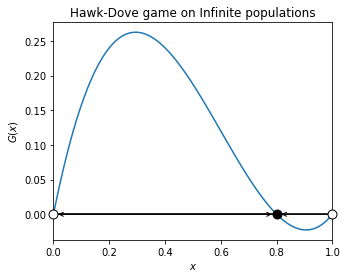

In [11]:
ax = plot_gradient(strategy_i, 
                   G, 
                   saddle_points, 
                   saddle_type, 
                   gradient_direction,
                   'Hawk-Dove game on Infinite populations', 
                   xlabel='$x$')
plt.show()

## Execise 3.2 : Evolutionary Dynamics of the Haw-Dove Game in Finite populations

Now we are going to study the effect of having Finite populations. In general, finite populations introduce stochastic effects in the dynamics, also known as random drift $~ 1/Z$, where $Z$ is the size of the population. We can represent these dynamics, by adapting the replicator equation, which considers that individuals are sampled from an infinite population, and therefore selecting a member of strategy $j$ does not reduce its frequency in the population. When the population is finite, we make no longer assume a sampling with replacement, i.e., when an individual of strategy $j$ is sampled, the fraction of members of that strategy is reduced, instead we must sample without replacement.

Here the fitness of an strategy $i$ against strategy $j$ directly depends on the size of the population:

$ f_i(x_i, Z) = \frac{x_i - 1}{Z-1} * A_{ii} + \frac{Z - x_i}{Z-1} * A_{ij} $

For the selection dynamics, we use a Moran process (or birth-death process) with pair-wise comparison: at each step, 2 individuals, $a$ and $b$, are randomly sampled (without replacement) from the population, and their payoff is compared. The fermi equation gives the probability that individual $a$ (selected for death) will copy the strategy of individual $b$ (selected for birth):

$p=[1 + e^{\beta(f_a-f_b)}]^{-1}$

$a$ will imitate $b$ with probability $p$, in any other case, the population state will not change. $\beta$ indicates the selection strength and on the limit $\beta \xrightarrow{} 0$ all strategies are immitated with equal probability.

In [12]:
from egttools.analytical import StochDynamics

In [13]:
# Parameters and evolver
nb_strategies = 2; Z = 100; N = 2;
beta = 1
pop_states = np.arange(0, Z + 1, 1)
strategy_i = np.linspace(0, 1, num=Z + 1, dtype=np.float64)
evolver = StochDynamics(nb_strategies, A, Z)

In [14]:
gradients = np.array([evolver.gradient_selection(x, 0, 1, beta) 
                      for x in pop_states])

In [15]:
# Find saddle points (where the gradient is 0) - Define epsilon correctly, or you will get wrong matches
epsilon = 1e-3
saddle_points_idx = np.where((gradients <= epsilon) & (gradients >= -epsilon))[0]
saddle_points = saddle_points_idx / Z

# Now let's find which saddle points are absorbing/stable and which aren't
# we also annotate the gradient's direction among saddle poinst
saddle_type, gradient_direction = find_saddle_type_and_gradient_direction(gradients, 
                                                                          saddle_points_idx)

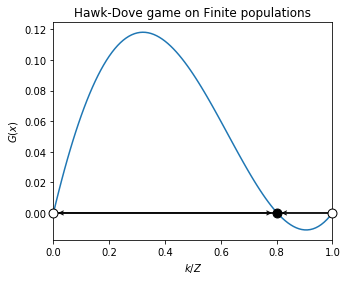

In [16]:
ax = plot_gradient(strategy_i, 
                   gradients, 
                   saddle_points, 
                   saddle_type, 
                   gradient_direction, 
                   'Hawk-Dove game on Finite populations', 
                   xlabel='$k/Z$')
plt.show()

#### Now let's calculate the stationary distribution

In [17]:
evolver.mu = 0
stationary_SML = evolver.calculate_stationary_distribution(beta)
print("time spent as Hawk: {} & time spent as Dove: {}".format(*stationary_SML))

time spent as Hawk: 1.0 & time spent as Dove: 0.0


#### Introducing mutations

If we introduce mutations, i.e., there is a probability that individuals make an error, and adopt a different strategy instead of imitating the best, the dynamics may change. In this case, at each time step, players are selected for death/birth and their fitness is compared. 

However, now, with probability $\mu$ agent $a$ will adopt a random strategy from the strategy space, and with probability $1-\mu$ it will immitate $b$ with probability $p$. Therefore the probability of immitating $b$ is $p_{eff} = (1-\mu)*p$. On the limit $\mu \xrightarrow{} 1$, all strategies are taken with equal probability. When $\mu \xrightarrow{} 0$ we go back to the previous case, also known as small mutation limit (SML). 

When mutation is small, we may assume that only the the states in which all population adopts a single strategy, also known as monomorphic states, are absorbing and stable. This is because, since there are no mutations, once the population reaches a monomorphic state, it will never leave. Such a simplification, allows us to reduce the number of states of the system, taking the Hawk-Dove game as an example, from Z + 1, to only 2.

Moreover, mixed equilibria are no longer stable in the SML. This occurs, since random drift, even if it takes an infinite ammount of time (please note that we are not looking at fixation times), will drive the population to one of the monomorphic states. For this reason, the SML assumption is only reasonable when we know that there are no mixed stable attractors in the studied system, which is not the case in the Hawk-Dove game. This explains why the results of the stationary distribution differ from the previously calculated Nash equilibria.

Now we are going to calculate the stationary distribution again, but taking mutations into account.

In [18]:
evolver.mu = 1e-3
stationary_with_mu = evolver.calculate_stationary_distribution(beta)

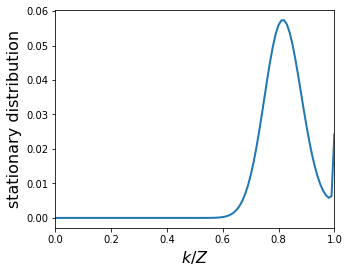

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor('white')
lines = ax.plot(np.arange(0, Z+1)/Z, stationary_with_mu)
plt.setp(lines, linewidth=2.0)
ax.set_ylabel('stationary distribution',size=16)
ax.set_xlabel('$k/Z$',size=16)
ax.set_xlim(0, 1)
plt.show()

### Questions
1. What is the effect of Population size?
2. What is the effect of beta?
3. What is the effect of mutations?

## Execise 3.3 : Moran Process with Pair-wise Comparison

Until now, we have calculated all our results analytically. This requires some expensive operations (matrix inversion) that are not allways possible. An example would be when the number of strategies is too large, making the number of states even larger. Or when we cannot use the SML simplification.

Your task will be to implement a simple version of a Moran process with pair-wise comparison as we expressed before, and use it to estimate the stationary distribution. To do that, you will need to perform Monte-carlo simulations, i.e., you start your population at a random state, wait a transitory period, and, afterwards, count how much time it spends on each state. Finally you repeat this process for several runs.

Please, write your implementation in a separate file named "moran_process.py" (you may also use C/C++/Java/Julia instead, but in this case you must also provide all necessary files to compile/run your code). You must implement 2 functions:
1. one called **moran_step(current_state, beta, mu, Z, A) -> next_state**. Where <em>current_state</em>, is the current state of the population, <em>beta</em> is the intensity of selection, <em>mu</em> is the mutation probability, <em>Z</em> is the population size, and <em>A</em> is the matrix that contains the payoffs of each strategy against each other. This function must return the next state of the population.
2. another called **estimate_stationary_distribution(nb_runs, transitory, nb_generations, beta, mu, Z, A) -> stationary_distribution**. Where <em>nb_runs</em>, is number of independent realizations of the Monte Carlo simulation, <em>transitory</em> is the transitory period, <em>nb_generations</em> is the number of generations to run the moran process, <em>beta</em> is the intensity of selection, <em>mu</em> is the mutation probability, <em>Z</em> is the population size, and <em>A</em> is the matrix that contains the payoffs of each strategy against each other. This function must return the stationary distribution of the population as a vector of floats containing the fraction of time the population spends in each possible state.

Assume that $\beta=10$, $\mu=10^{-3}$, $Z=50$, $V=2$, $D=3$ and $T=1$. Also, transitory $=10^3$, nb_generations $=10^5$ and the nb_runs $=10$. 

3. You should provide a main loop that executes your code and produces the appropiate results. If your code is written in python, it should be possible to execute it as: python moran_process.py. If it is written in C/C++, it should be possible to execute it with ./moran_process. For any other language you choose, you should provide information on how to exectue your code, taking into account that your executable should always be called "moran_process.[extension]". No parameters should be input to the executable by command line, it should use the default parameters indicated above.